In [ ]:
from imutils import face_utils
from collections import OrderedDict
import dlib
import cv2
import numpy as np
from scipy.spatial import distance as dist

Using dlib's shape predector, 68 face landmarks model and Eyes Ratio Method (EAR), we're going to build a real-time face detector that reports the general state of the eyes, month (open/close) and head (left, right, straight).
This snippet can also be used as a kind of liveness detection method for authentication systems.


Here is the model of 68 face landmarks.

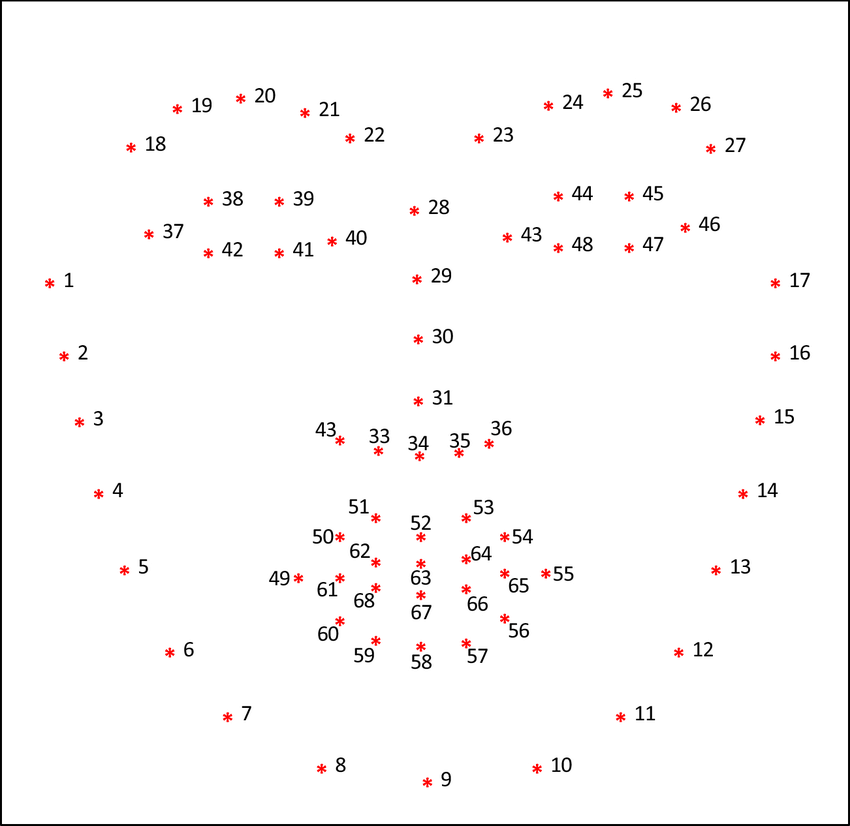

In [ ]:
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

FACIAL_LANDMARKS_IDXS = OrderedDict([
        ("mouth", (48, 68)),
        ("right_eyebrow", (17, 22)),
        ("left_eyebrow", (22, 27)),
        ("right_eye", (36, 42)),
        ("left_eye", (42, 48)),
        ("nose", (27, 36)),
        ("jaw", (0, 17))
    ])

Define the threshold for what we mean by "close", "open", "right", etc.

In [ ]:
EYE_AR_THRESH = 0.21
RATIO_THRESH = 0.0010
MOUTH_AR_THRESH = 0.32
LEFT_AR_THRESH = 1.6
RIGHT_AR_THRESH = 0.6


In EAR method, aslo known as MAR (Mouth Aspect Ratio), we compute the euclidean distances between the two sets of vertical landmarks and a set of horizontal eye landmark (x, y)-coordinates; then, apply the following formula.

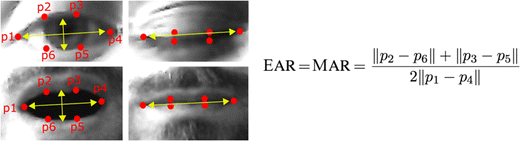

In [ ]:
def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(x1, x2, x3, x4):
    A = dist.euclidean(x1, x2)
    B = dist.euclidean(x3, x4)
    return A / B


def turn_aspect_ratio(x1, x2, x3):
    A = dist.euclidean(x1, x2)
    B = dist.euclidean(x2, x3)
    return A / B
    

Starting the Real-time Face and liveness Detector...

In [ ]:
cap = cv2.VideoCapture(0)
 
while True:
    # load the input image and convert it to grayscale
    _, image = cap.read()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    # detect faces in the grayscale image
    rects = detector(gray, 0)
    
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        
        # create a bounding box around the face
        face_width=shape[16,0]-shape[0,0]
        face_height=(shape[8,1]-shape[0,1])*1.5
        cv2.rectangle(image, (int(shape[0,0]),int(shape[8,1])), (int(shape[16,0]),int(shape[8,1]-face_height)), (255,0,0), 2)
        
        # applying ear
        ratio = turn_aspect_ratio(shape[0], shape[27], shape[16])
        lips_ratio = mouth_aspect_ratio(shape[62], shape[66], shape[49], shape[59])
        
        (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
        (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)

        ear = (leftEAR + rightEAR) / 2.0
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        ear_ratio = ear / w
        
        
        if lips_ratio > MOUTH_AR_THRESH:
            cv2.putText(image,'Mouth Open', 
                (10,400), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1,
                (255,255,255),
                1,
                2)
        else:
            cv2.putText(image,'Mouth Close', 
                (10,400), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1,
                (255,255,255),
                1,
                2)
            
        if ratio < RIGHT_AR_THRESH:
            cv2.putText(image,'Looking Right', 
                (10,450), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1,
                (255,255,255),
                1,
                2)
        elif ratio > LEFT_AR_THRESH:
            cv2.putText(image,'Looking Left', 
                (10,450), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1,
                (255,255,255),
                1,
                2)
        else:
            cv2.putText(image,'Looking Straight', 
                (10,450), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1,
                (255,255,255),
                1,
                2)
        
        
        if ear_ratio > RATIO_THRESH:
            cv2.putText(image,'Eyes Open', 
                (10,350), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1,
                (255,255,255),
                1,
                2)
        else:
            cv2.putText(image,'Eyes Close', 
                (10,350), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1,
                (255,255,255),
                1,
                2)    
                

    cv2.imshow("Output", image)
    
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break

cv2.destroyAllWindows()
cap.release()

### Considerations
you can either run the detect.py using the following command

**python detect.py**

or use the detect.ipynb jupyter notebook